# Problem Statement
In Toronto, many families choose to become an Airbnb host to compensate their realty mortgage cost. When searching for a cozy temporary home, people choose hosts based on a variety of reasons, for example hosts with most reviews, beautiful staging pictures, reasonable prices and much more. However, not every host is good at promoting their homes, or they can be inexperienced at hospitality that drives their reviews down and hurt their revenue. Our project aims to help those bottoms of the list stay afloat in Airbnb business, finding what are possible factors driving their occupancy rate and review scores.  
# Data
### Key Variables
**Listing features**: First date since host went live, Response time range, Response percentage, Airbnb authorized superhost, # of listing owned by host, Types of verification needed from guests, if host has profile picture, if host identity is verified, neighborhood, location, property type, room type, default number of guests, # of bathrooms, # of bedrooms, # of beds, bed type, amenities, price, cleaning fee, fee for extra people, minimum and maximum nights, cancellation policy, if require guest picture, if require guest phone verification.

**Review features**: Total number of reviews, last review date, review score rating, accuracy score, cleanliness score, check-in score, communication score, location score, value score, if instant bookable.

**Target variable**: Occupancy index = Reviews per month * Review score rating.

Airbnb as a “Sharing Economy” company scrapes their own database of reviews, listings and calendars on a monthly basis, and posted on Inside Airbnb (insideairbnb.com). We will focus on listing data which contains up-to-date review scores, review counts and hosts’ listing features. From there, we can study what is actually impacting listing popularity and scores. 

However occupancy is not provided in the dataset due to privacy reasons, we chose to create an indicator of reviews per month * review scores rating. Although reviews per month does not equals to occupancy rate, but it is still an indicator of the listing popularity. 
# Methods
After feature engineering including one-hot encoding on categorical variables and nested-lists, we have more than 400 features created for this model. To avoid overfitting and multicollinearity, we used L1, L2 and Elastic Net regression for variable selection and obtain feature importance. For loss function, we chose Rooted Mean Squared Error (RMSE) because it is widely used in regression. And then we will move on to more robust modeling methods such as decision tree, random forest and xgboost, etc. We could move back to data engineering to create more features or find more outside data to support our model.


## Loading data and data engineering

In [26]:
import pandas as pd
import numpy as np
import ast
from decimal import Decimal
from datetime import timedelta, datetime
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [27]:
listing = pd.read_csv('listings.csv', index_col = "id", low_memory = False)

In [5]:
listing.head()

,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,...,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,
1419,https://www.airbnb.com/rooms/1419,20181206023116,2018-12-06,Beautiful home in amazing area!,"This large, family home is located in one of T...",Visit Toronto with this fabulous furnished hom...,"This large, family home is located in one of T...",none,The apartment is located in the Ossington stri...,"To learn a little more about our home, see: (U...",...,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,0.17
8077,https://www.airbnb.com/rooms/8077,20181206023116,2018-12-06,Downtown Harbourfront Private Room,Guest room in a luxury condo with access to al...,My husband and I are both artists. I give pain...,Guest room in a luxury condo with access to al...,none,NaN,NaN,...,f,NaN,NaN,t,f,strict_14_with_grace_period,f,t,2,1.50
10314,https://www.airbnb.com/rooms/10314,20181206023116,2018-12-06,Union Inn II (Leslieville),We offer a private room for two with a queen b...,"The 'union inn' offers a clean, spacious room ...",We offer a private room for two with a queen b...,none,Our charming adopted home of Leslieville is a ...,"Clean towels, a hair dryer, soap and sanitary ...",...,f,NaN,NaN,f,f,moderate,f,f,1,0.68
12604,https://www.airbnb.com/rooms/12604,20181206023116,2018-12-06,Seaton Village Parlour Bedroom,Comfortable sofa bed in airy main floor parlour.,Family of 4 (2 kids) plus a friendly dog open...,Comfortable sofa bed in airy main floor parlou...,none,NaN,NaN,...,f,NaN,NaN,f,f,moderate,f,f,1,NaN
23691,https://www.airbnb.com/rooms/23691,20181206023116,2018-12-06,Queen Bedroom close to downtown,NaN,Nestled in the middle of a quiet residential n...,Nestled in the middle of a quiet residential n...,none,NaN,* Laundry facilities are available at the prem...,...,f,NaN,NaN,t,f,strict_14_with_grace_period,f,f,2,1.99


## Cherry pick valueble independent variables
| colname                          | description                         |
|----------------------------------|-------------------------------------|
| host_since                       | First date since host went live     |
| host_response_time               | Response time range                 |
| host_response_rate               | Response percentage                 |
| host_is_superhost                | Airbnb authorized superhost T/F     |
| host_listings_count              | # of listing owned by host          |
| host_verifications               | Types of verification needed from guests        |
| host_has_profile_pic             | T/F                                 |
| host_identity_verified           | T/F                                 |
| neighbourhood_cleansed           | Sub-region of Toronto               |
| smart_location                   | Cleaned city location               |
| is_location_exact                | T/F                                 |
| property_type                    | House/Condo/etc                     |
| room_type                        | Private/Share                       |
| accommodates                     | max guests                          |
| bathrooms                        | # of bathrooms                      |
| bedrooms                         | # of bedrooms                       |
| beds                             | # of beds                           |
| bed_type                         | bed/sofa/etc                        |
| amenities                        | TV/internet/etc                     |
| price                            | One-day price                       |
| weekly_price                     |                                     |
| monthly_price                    |                                     |
| security_deposit                 |                                     |
| cleaning_fee                     |                                     |
| guests_included                  | default allowed guest number        |
| extra_people                     | cost of additional people per night |
| minimum_nights                   |                                     |
| maximum_nights                   |                                     |
| number_of_reviews                | Total number of reviews             |
| last_review                      | Date of latest review               |
| review_scores_rating             | 0-100                               |
| review_scores_accuracy           | 2-10                                |
| review_scores_cleanliness        | 2-10                                |
| review_scores_checkin            | 2-10                                |
| review_scores_communication      | 2-10                                |
| review_scores_location           | 2-10                                |
| review_scores_value              | 2-10                                |
| instant_bookable                 | T/F                                 |
| cancellation_policy              | moderate/strict/etc                 |
| require_guest_profile_picture    | T/F                                 |
| require_guest_phone_verification | T/F                                 |
| reviews_per_month                | 0-30                                |

In [28]:
sub_colnames = ['host_since', 'host_response_time', 'host_response_rate', 'host_is_superhost', 'host_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_cleansed', 'smart_location', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'cancellation_policy', 'require_guest_profile_picture', 'require_guest_phone_verification', 'reviews_per_month']

In [29]:
Airbnb = listing[sub_colnames]
print('Total Rows:', Airbnb.shape[0])

Total Rows: 19255


### Remove all inactive users
Users who never respond customers are considered as inactive hosts.

In [30]:
# Drop NA
Airbnb = Airbnb.dropna(subset = ['host_response_time', 'host_response_rate', 'host_is_superhost', 'reviews_per_month', 'review_scores_rating'])
print('Total Rows After Dropping NA:', Airbnb.shape[0])

Total Rows After Dropping NA: 9447


### Basic Data Cleaning
Turn percentage to float and turn Ture/False to 1 or 0

In [31]:
# Percentage to float
Airbnb['host_response_rate'] = Airbnb.host_response_rate.str.rstrip('%').astype('float')
# True or False to 1 or 0
Airbnb[['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'is_location_exact', 'instant_bookable', 'require_guest_profile_picture', 'require_guest_phone_verification']] = Airbnb[['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'is_location_exact', 'instant_bookable', 'require_guest_profile_picture', 'require_guest_phone_verification']].eq('t').mul(1)

In [32]:
# Convert currency to float
Airbnb['price'] = pd.to_numeric(Airbnb['price'].str.lstrip('$').str.replace(",",""))
Airbnb['weekly_price'] = pd.to_numeric(Airbnb['weekly_price'].str.lstrip('$').str.replace(",",""))
Airbnb['monthly_price'] = pd.to_numeric(Airbnb['monthly_price'].str.lstrip('$').str.replace(",",""))
Airbnb['security_deposit'] = pd.to_numeric(Airbnb['security_deposit'].str.lstrip('$').str.replace(",",""))
Airbnb['cleaning_fee'] = pd.to_numeric(Airbnb['cleaning_fee'].str.lstrip('$').str.replace(",",""))
Airbnb['extra_people'] = pd.to_numeric(Airbnb['extra_people'].str.lstrip('$').str.replace(",",""))

In [33]:
Airbnb['weekly_price'].fillna(Airbnb['price']*7, inplace = True)
Airbnb['monthly_price'].fillna(Airbnb['price']*30, inplace = True)
Airbnb['security_deposit'].fillna(0, inplace = True)
Airbnb['cleaning_fee'].fillna(0, inplace = True)

### Turn host_since to length of years of hosting and last_review to length of months

In [34]:
Airbnb['host_since'] = pd.to_datetime(Airbnb['host_since'], format = '%Y-%m-%d')
Airbnb['host_years'] = (datetime.strptime('2018-12-06', '%Y-%m-%d') - Airbnb['host_since']) / timedelta(days = 365)
Airbnb.drop(columns = 'host_since', axis = 1, inplace = True)

In [35]:
Airbnb['last_review'] = pd.to_datetime(Airbnb['last_review'], format = '%Y-%m-%d')
Airbnb['months_since_last_review'] = (datetime.strptime('2018-12-06', '%Y-%m-%d') - Airbnb['last_review']) / timedelta(days = 30)
Airbnb.drop(columns = 'last_review', axis = 1, inplace = True)

### One-hot encoding for nested lists: host_verifications and amenities
```
https://stackoverflow.com/questions/45312377/how-to-one-hot-encode-from-a-pandas-column-containing-a-list
```

In [36]:
mlb = MultiLabelBinarizer()
Airbnb['host_verifications'] = Airbnb['host_verifications'].apply(ast.literal_eval)
Airbnb = Airbnb.join(pd.DataFrame(mlb.fit_transform(Airbnb.pop('host_verifications')),
                          columns=mlb.classes_,
                          index=Airbnb.index))

In [37]:
# Formatting
Airbnb['amenities'] = Airbnb['amenities'].str.replace("{","")
Airbnb['amenities'] = Airbnb['amenities'].str.replace("}","")
Airbnb['amenities'] = Airbnb['amenities'].str.replace('"', '')
Airbnb['amenities'] = Airbnb['amenities'].str.replace(" ", "")
Airbnb['amenities'] = Airbnb['amenities'].str.replace(',', ' ')
Airbnb['amenities'] = Airbnb['amenities'].str.split()
Airbnb['amenities_count'] = Airbnb['amenities'].apply(len)

In [38]:
mlb = MultiLabelBinarizer()
Airbnb = Airbnb.join(pd.DataFrame(mlb.fit_transform(Airbnb.pop('amenities')),
                          columns=mlb.classes_,
                          index=Airbnb.index))

### One-hot encoding for categorical data

In [39]:
Airbnb = pd.get_dummies(Airbnb, prefix = ['host_response_time','neighbourhood','smart_location','property_type','room_type', 'bed_type', 'cancellation_policy'], columns = ['host_response_time','neighbourhood_cleansed','smart_location','property_type', 'room_type', 'bed_type', 'cancellation_policy'])

### Adding price_per_guest attribute into Airbnb

In [40]:
Airbnb['price_per_guest'] = Airbnb['price'] / Airbnb['guests_included']
#Airbnb.drop('price', axis = 1, inplace = True)

### Adding Occupancy_index as target variable

In [41]:
Airbnb['Occupancy_index'] = Airbnb['reviews_per_month'] * Airbnb['review_scores_rating']
#Airbnb['Occupancy_index_copy'] = Airbnb['Occupancy_index']
Airbnb['Occupancy_index'] = Airbnb['Occupancy_index'].apply(np.sqrt)
Airbnb.drop(['reviews_per_month', 'review_scores_rating', 'review_scores_value'], axis = 1, inplace = True)

In [42]:
listing['Occupancy_index'] = listing['reviews_per_month'] * listing['review_scores_rating']
#listing['Occupancy_index_copy'] = listing['Occupancy_index']
listing['Occupancy_index'] = listing['Occupancy_index'].apply(np.sqrt)

## Exploring the data
visualize the data with a histogram.

In [21]:
listing = listing.loc[Airbnb.index]

In [22]:
listing[['price','neighbourhood_cleansed']].groupby('neighbourhood_cleansed').count().nlargest(6, 'price')
community_index = listing[['price','neighbourhood_cleansed']].groupby('neighbourhood_cleansed').count().nlargest(6, 'price').index.values

In [23]:
s = listing[['price','neighbourhood_cleansed']].groupby('neighbourhood_cleansed').count().nlargest(6, 'price')
s.columns = ['Listing_Count']
s

,Listing_Count
neighbourhood_cleansed,
Waterfront Communities-The Island,2104
Niagara,470
Annex,367
Church-Yonge Corridor,351
Dovercourt-Wallace Emerson-Junction,345
Kensington-Chinatown,314


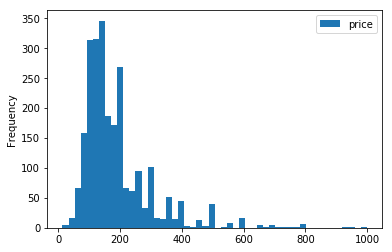

In [52]:
listing[(listing['neighbourhood_cleansed'] == community_index[0]) & (listing['price'] < 1000)][['price']].plot.hist(bins = 50)
plt.show()

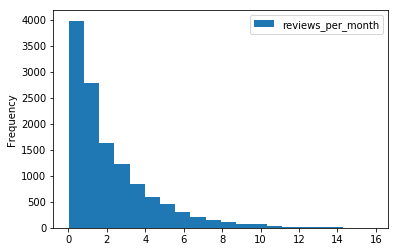

In [22]:
listing[['reviews_per_month']].plot.hist(bins=20)

## Comparison between before and after sqrt transfer
### Now it is more normlaized

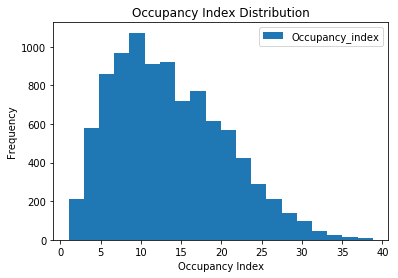

In [101]:
listing[['Occupancy_index']].plot.hist(bins=20)
plt.title('Occupancy Index Distribution')
plt.xlabel('Occupancy Index')
plt.show()

Create a figure with boxplot that display the distribution of mean squared error and r-squared values.

22.05425129085093

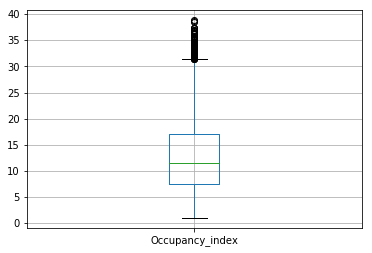

In [26]:
plt.figure()
listing.boxplot(column='Occupancy_index')
listing['Occupancy_index'].quantile(0.9)

In [ ]:
listing.boxplot(column='reviews_per_month')
listing['reviews_per_month'].quantile(0.25)

In [25]:
listing['price'] = pd.to_numeric(listing['price'].str.lstrip('$').str.replace(",",""))
listing['price_per_guest'] = listing['price'] / listing['guests_included']

In [64]:
low_occupancy_listing = listing[listing['Occupancy_index'] < 16]
high_occupancy_listing = listing[listing['Occupancy_index'] > 16]

In [47]:
HousePercent_low = low_occupancy_listing[low_occupancy_listing['property_type'] == 'House'].shape[0] / low_occupancy_listing.shape[0]
print('House take {}% of total listings in low occupancy hosts'.format(round(HousePercent_low * 100,2)))

House take 24.35% of total listings in low occupancy hosts


In [67]:
low_occupancy = low_occupancy_listing[['property_type', 'Occupancy_index']].groupby(['property_type']).count().sort_values(by = ['Occupancy_index'], ascending = False)
high_occupancy = high_occupancy_listing[['property_type', 'Occupancy_index']].groupby(['property_type']).count().sort_values(by = ['Occupancy_index'], ascending = False)

In [68]:
from plotly import tools
import plotly.plotly as py
import plotly.graph_objs as go

High_Occupancy = go.Bar(
    x=high_occupancy.index.values,
    y=high_occupancy.Occupancy_index.values,
    name = 'High Occupancy'
)

Low_Occupancy = go.Bar(
    x=low_occupancy.index.values,
    y=low_occupancy.Occupancy_index.values,
    xaxis='x2',
    yaxis='y2',
    name = 'Low Occupancy'
)


data = [High_Occupancy, Low_Occupancy]

layout = go.Layout(
    xaxis=dict(
        domain=[0, 0.45]
    ),
    yaxis=dict(
        domain=[0, 1]
    ),
    xaxis2=dict(
        domain=[0.55, 1]
    ),
    yaxis2=dict(
        domain=[0, 1],
        anchor='x2'
    )
)

fig = go.Figure(data=data, layout=layout)
fig['layout'].update(title='High Occupancy vs Low Occupancy by Property Type')
py.iplot(fig, filename='text-hover-bar')

## Prediction start here
## Use Lasso, Ridge and ElasticNet for variable selection

In [70]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
import warnings
warnings.filterwarnings("ignore")

In [71]:
Airbnb.fillna(0, inplace = True)
y = Airbnb['Occupancy_index']
X = Airbnb.drop(['Occupancy_index'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Grid Search for Ridge Regression

In [72]:
alphas = np.array([1,0.1,0.3,0.5, 0.7,0.9])
fit_interceptOptions = ([True, False])
solverOptions = (['svd', 'cholesky', 'sparse_cg', 'sag'])
model = Ridge(normalize=True)
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas, fit_intercept=fit_interceptOptions, solver=solverOptions), cv=10)

grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'solver': ['svd', 'cholesky', 'sparse_cg', 'sag'], 'fit_intercept': [True, False], 'alpha': array([1. , 0.1, 0.3, 0.5, 0.7, 0.9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [24]:
#print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.alpha)
print(grid.best_estimator_.fit_intercept)
print(grid.best_estimator_.solver)

0.4458661818099414
0.3
True
sag


In [73]:
ridge = Ridge(normalize=True,
             alpha = grid.best_estimator_.alpha,
             fit_intercept = grid.best_estimator_.fit_intercept,
             solver = grid.best_estimator_.solver)

rsquared = np.mean(cross_val_score(ridge, X, y, scoring = 'r2', cv=10))
print('Ridge R2:{}'.format(rsquared))

Ridge R2:0.285277774171858


In [31]:
cross_val_score(ridge, X, y, scoring = 'r2', cv=10)

array([-0.78803054,  0.49603537,  0.48975145,  0.4542695 ,  0.42347933,
        0.42233055,  0.4500854 ,  0.42027881,  0.37364584,  0.16036422])

### Grid Search for Lasso Regression

In [75]:
alphas = np.array([1,0.1,0.3,0.5, 0.7,0.9, 0.01])
fit_interceptOptions = ([True, False])

model = Lasso(normalize=True)
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas, fit_intercept=fit_interceptOptions))

grid.fit(X_train, y_train)
lasso = Lasso(normalize=True,
             alpha = grid.best_estimator_.alpha,
             fit_intercept = grid.best_estimator_.fit_intercept)

rsquared = np.mean(cross_val_score(lasso, X, y, scoring = 'r2', cv=10))
print('Lasso R2:{}'.format(rsquared))

Lasso R2:0.2682966135611601


In [76]:
cross_val_score(lasso, X, y, scoring = 'r2', cv=10)

array([-1.0505029 ,  0.47587457,  0.49955043,  0.47807039,  0.45042881,
        0.42582284,  0.45603021,  0.41558521,  0.36214476,  0.16996181])

### Grid Search for Decision Tree and Decision Tree + Feature Selection from Lasso

In [77]:
from sklearn.linear_model import LassoCV
lasso = Lasso(normalize=True,
             alpha = grid.best_estimator_.alpha,
             fit_intercept = grid.best_estimator_.fit_intercept)
lasso.fit(X,y)
model = SelectFromModel(lasso, prefit=True)
X_new = model.transform(X)
X_new
feature_idx = model.get_support()
lasso_feature_name = X.columns[feature_idx]

parameters={'min_samples_split' : range(10,20),'max_depth': range(5,10)}
clf_tree=DecisionTreeRegressor()
clf=GridSearchCV(clf_tree,parameters)

rsquared = np.mean(cross_val_score(clf, X, y, scoring = 'r2', cv=10))
print('decision tree w/o Lasso Features R2:{}'.format(rsquared))
rsquared = np.mean(cross_val_score(clf, X[lasso_feature_name ], y, scoring = 'r2', cv=10))
print('decision tree w/ Lasso Features R2:{}'.format(rsquared))

decision tree w/o Lasso Features R2:0.47011548231024236
decision tree w/ Lasso Features R2:0.47209230573194294


In [45]:
## Find best decision tree
parameters={'min_samples_split' : range(10,20),'max_depth': range(5,10)}
clf_tree=DecisionTreeRegressor()
grid=GridSearchCV(clf_tree,parameters,cv=10)
grid.fit(X_train, y_train)
clf = DecisionTreeRegressor(min_samples_split = grid.best_estimator_.min_samples_split,
             max_depth = grid.best_estimator_.max_depth)

In [121]:
y_lower_index = y[y<y.quantile(0.25)].index
y_upper_index = y[(y>y.quantile(0.25)) & (y<=y.quantile(0.75))].index


In [120]:
np.mean(cross_val_score(clf, X, y, scoring = 'r2', cv=10))

0.40263401045072567

In [122]:
np.mean(cross_val_score(clf, X.loc[y_upper_index], y.loc[y_upper_index], scoring = 'r2', cv=10))

-0.08652152834078389

In [108]:
cross_val_score(clf, X, y, scoring = 'r2', cv=10)

array([0.34639703, 0.52541543, 0.44498115, 0.51746904, 0.49732009,
       0.54340322, 0.48820071, 0.2537747 , 0.367428  , 0.03248373])

In [46]:
clf.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=7, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=16, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

### Grid Search Regression for Elastic Net

In [133]:
alphas = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10, 100])
max_iter = np.array([1,5,10])
l1_ratio = np.arange(0.0, 1.0, 0.1)
fit_interceptOptions = ([True, False])

model = ElasticNet(normalize=True)
grid = GridSearchCV(estimator=model, param_grid=dict(fit_intercept=fit_interceptOptions, max_iter = max_iter, l1_ratio = l1_ratio))

grid.fit(X_train, y_train)
elasticnet = ElasticNet(normalize=True,
             alpha = grid.best_estimator_.alpha,           
             fit_intercept = grid.best_estimator_.fit_intercept,
             max_iter = grid.best_estimator_.max_iter,
             l1_ratio = grid.best_estimator_.l1_ratio)

In [90]:
alphas = np.array([10, 1,0.3,0.5, 0.7,0.9,0])
max_iter = np.array([5,20])
l1_ratio = np.array([0,0.1,0.3,0.5,0.7,1])
fit_interceptOptions = ([True, False])

model = ElasticNet(normalize=True)
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas, fit_intercept=fit_interceptOptions, max_iter = max_iter, l1_ratio = l1_ratio))

grid.fit(X_train, y_train)
elasticnet = ElasticNet(normalize=True,
             alpha = grid.best_estimator_.alpha,
             fit_intercept = grid.best_estimator_.fit_intercept,
             max_iter = grid.best_estimator_.max_iter,
             l1_ratio = grid.best_estimator_.l1_ratio)

In [145]:
np.mean(cross_val_score(elasticnet, X, y, scoring = 'r2', cv=10))

-2.2921894595555234

## Stack Ensembled Model

In [95]:
from sklearn.metrics import r2_score as r2
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet

def stack_models(X,models):
    
    stack_features = pd.DataFrame(index=X.index)
    for i, mdl in enumerate(models):
        stack_features['mdl_{}'.format(i)]=mdl.predict(X)
    X=pd.concat([X,stack_features],axis=1)
    
    return X
def mdl_eval(mdl,xVals,yVals,xTest,yTest):
    mdl.fit(xVals,yVals)
    yPred=mdl.predict(xTest)
    RSquared=cross_val_score(mdl,xTest,yTest,scoring='r2',cv=10)
    return np.mean(RSquared)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


all_models={}
#all_models['ridge']=(ridge,mdl_eval(ridge,X_train,y_train,X_test,y_test))
#all_models['lasso']=(lasso,mdl_eval(lasso,X_train,y_train,X_test,y_test))
all_models['elasticnet']=(elasticnet,mdl_eval(elasticnet,X_train,y_train,X_test,y_test))
all_models['clf']=(clf,mdl_eval(clf,X_train,y_train,X_test,y_test))
best_params_models = [all_models[key][0]for key in all_models.keys()]
print(all_models)
x_train_grid_search = stack_models(X_train,best_params_models)
x_test_grid_search = stack_models(X_test,best_params_models)


from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier

stack_tree=DecisionTreeRegressor()

for nEst in [1, 5, 15, 50, 200]:
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    mdlAcc=[]
    mdl_stack=RandomForestRegressor(n_estimators=nEst,max_features=0.2)
    mdl_stack.fit(x_train_grid_search, y_train)
    #mdlAcc = np.mean((randMdl.predict(x_train) == y_train))
    yPred=mdl_stack.predict(x_test_grid_search)
    R_2=cross_val_score(mdl_stack,x_test_grid_search,y_test,scoring='r2',cv=10)
    mdlAcc.append(R_2)
    #print(mdlAcc)
    
#mdl_stack = Ridge(normalize=True)
#mdl_stack.fit(x_train_grid_search,y_train)
#y_pred=mel_stack(x_test_grid_search)
#R_2=
#mdl_eval(mdl_stack,x_train_grid_search,y_train,x_test_grid_search,y_test)
#mdl_eval(stack_tree,x_train_grid_search,y_train,x_test_grid_search,y_test)


{'elasticnet': (ElasticNet(alpha=0.0, copy_X=True, fit_intercept=True, l1_ratio=0.0,
      max_iter=20, normalize=True, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False), 0.39974005479518804), 'clf': (DecisionTreeRegressor(criterion='mse', max_depth=7, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=19, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'), 0.4739763777624577)}


In [134]:
mdl_eval(mdl_stack,x_train_grid_search,y_train,x_test_grid_search,y_test)

0.657613502811486

# Simulation of User Behaviours

### Airbnb published anonymous user session data of browsing Airbnb website, including user action, decision making and time consumption

In [28]:
session = pd.read_csv("sessions.csv")
session.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [29]:
print("There are total {} users, {} of them payed for a stay.".\
      format(len(session['user_id'].unique()), 
             len(session[session['action'] == 'pay']['user_id'].unique())))

There are total 135484 users, 1669 of them payed for a stay.


### We will be focusing on users who booked a stay
#### Within "action_detail", the "view_search_results" value indicate the user actually click into a certain listing
#### This indicates how many listings are viewed by user

In [101]:
search_result = session[session['action_detail'] == 'view_search_results']

In [102]:
search_agg = search_result[['user_id', 'action_detail']].groupby(['user_id'], as_index = False).count()
search_agg.head()

,user_id,action_detail
0,00023iyk9l,5
1,0010k6l0om,10
2,001wyh0pz8,66
3,0028jgx1x1,9
4,002qnbzfs5,125


#### Find users that are actually paying for a stay

In [103]:
payed_user = session[session['action'] == 'pay']['user_id'].unique()

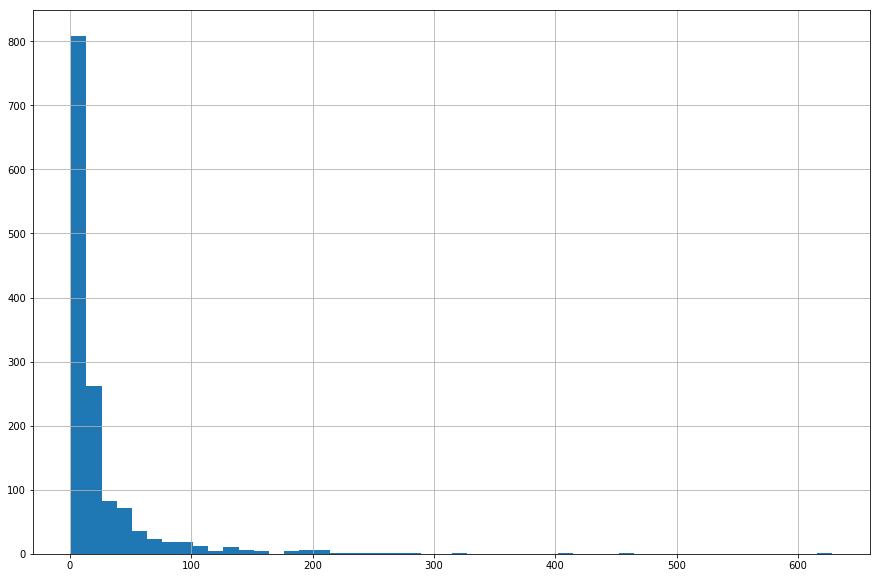

In [104]:
search_agg_payed = search_agg[search_agg['user_id'].isin(payed_user)]
fig = plt.figure(figsize = (15,10))
search_agg_payed['action_detail'].hist(bins = 50)

### As we can see from the histogram above, most of the users make less than 5 views. We want to clean the data make it more normal
#### Minimum number of views : 5, Maximum number of views: 95% quantile. Impute ourliers to be a random integer

In [105]:
search_agg_payed_clean = search_agg_payed
search_agg_payed_clean['action_detail'][search_agg_payed_clean['action_detail'] <= 5] = search_agg_payed_clean['action_detail'][search_agg_payed_clean['action_detail'] < 5].apply(lambda v: np.abs(np.rint(np.random.normal(search_agg_payed['action_detail'].median(),search_agg_payed['action_detail'].std()))))
search_agg_payed_clean['action_detail'][search_agg_payed_clean['action_detail'] > search_agg_payed['action_detail'].quantile(0.95)] = search_agg_payed_clean['action_detail'][search_agg_payed_clean['action_detail'] > search_agg_payed['action_detail'].quantile(0.95)].apply(lambda v: np.abs(np.rint(np.random.normal(search_agg_payed['action_detail'].median(),search_agg_payed['action_detail'].std()))))
search_agg_payed_clean['action_detail'][search_agg_payed_clean['action_detail'].isna()] = search_agg_payed_clean['action_detail'][search_agg_payed_clean['action_detail'].isna()].apply(lambda v: np.abs(np.rint(np.random.normal(search_agg_payed['action_detail'].median(),search_agg_payed['action_detail'].std()))))

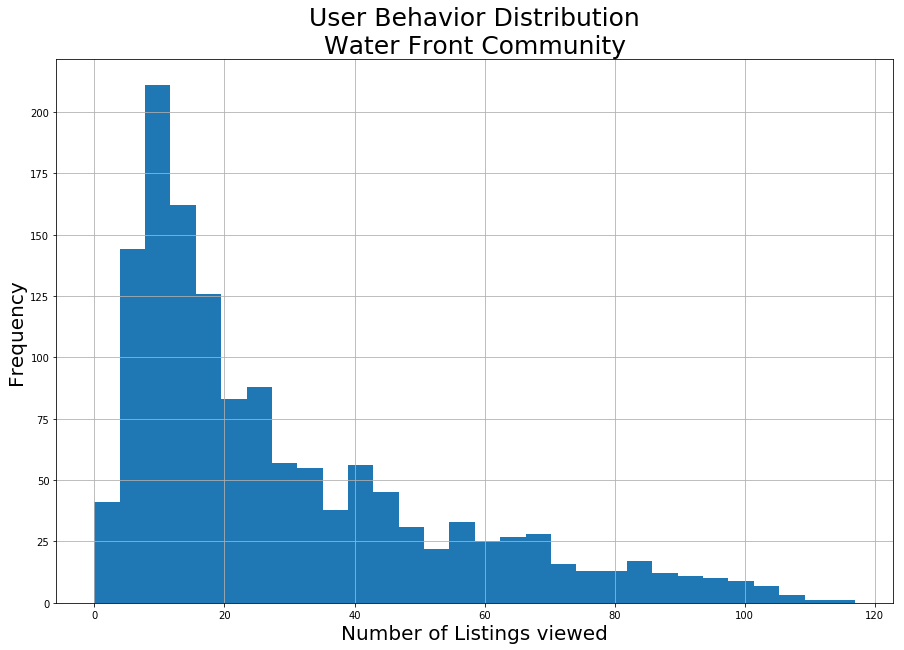

In [106]:
fig = plt.figure(figsize = (15,10))
search_agg_payed_clean['action_detail'].hist(bins = 30)
plt.xlabel('Number of Listings viewed',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.title('User Behavior Distribution\nWater Front Community', fontsize = 25)
plt.show()

### Now we choose one community as our case study
### THE WATERFRONT COMMUNITIES – THE ISLAND

![map](img/waterfront.png)

In [107]:
Search_Airbnb = Airbnb[Airbnb['neighbourhood_Waterfront Communities-The Island'] == 1]

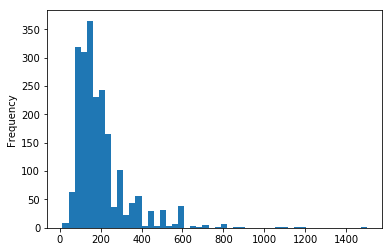

In [108]:
Search_Airbnb['price'].plot.hist(bins=50)

(1420, 428)


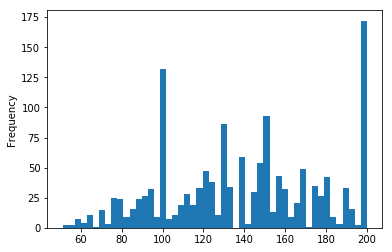

In [109]:
Search_Airbnb = Search_Airbnb[(Search_Airbnb['price'] >= 50) & (Search_Airbnb['price'] <= 200) & (Search_Airbnb['accommodates'] >= 2)]
Search_Airbnb['price'].plot.hist(bins=50)
print(Search_Airbnb.shape)

### We will focus on price range within 50 to 200 and Guest # >= 2
#### Sample use decision tree model

In [110]:
# decision tree clf
y = Search_Airbnb['Occupancy_index']
X = Search_Airbnb.drop('Occupancy_index', axis = 1)

In [111]:
def sample_occpancy(mdl, x):
    '''Gererate occupancy index based on listing features x.
    
    Input:  mdl is regression model
            x is 1-dim numpy array
    Output: Occupancy Index
    '''
    Occupancy_Index = mdl.predict(x)
    return Occupancy_Index
#sample_occpancy(clf, X.iloc[[1], :])[0]

(1420, 428)


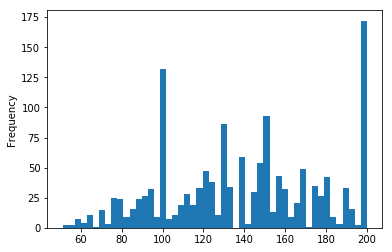

In [112]:
Search_Airbnb = Search_Airbnb[(Search_Airbnb['price'] >= 50) & (Search_Airbnb['price'] <= 200) & (Search_Airbnb['accommodates'] >= 2)]
Search_Airbnb['price'].plot.hist(bins=50)
print(Search_Airbnb.shape)

In [113]:
User_Pool = search_agg_payed_clean.set_index('user_id')
User_Pool.columns = ['Listing_Viewed']
User_Pool.head()

,Listing_Viewed
user_id,
002qnbzfs5,9.0
02sjeoorpr,79.0
03ql8i57t4,8.0
044959ww4h,68.0
04kwu8wbay,19.0


### From our model, here's the top 10 important features
#### We sill study the change in minimum_nights, host_is_superhost, price_per_guest, monthly_price and cleaning_fee

0.14

In [62]:
f_importance = pd.DataFrame({'Feature': X_test.columns, 'Importance': clf.feature_importances_})
f_importance.nlargest(20, 'Importance')

,Feature,Importance
28,months_since_last_review,0.740514
17,minimum_nights,0.112610
27,host_years,0.054620
2,host_listings_count,0.015130
14,cleaning_fee,0.014187
11,weekly_price,0.013151
1,host_is_superhost,0.013015
20,review_scores_cleanliness,0.009710
194,Selfcheck-in,0.009666
6,accommodates,0.006757


### We will be looking at listing id 146601

In [115]:
Search_Airbnb['Occupancy_index'].median()

16.603912576708865

In [116]:
listing.loc[Search_Airbnb[(Search_Airbnb['Occupancy_index'] > 16) & (Search_Airbnb['price'] < 150)].index]

,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,...,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,Occupancy_index
id,,,,,,,,,,,,,,,,,,,,,
925491,https://www.airbnb.com/rooms/925491,20181206023116,2018-12-06,Suite Toronto Luxury Downtown Condo,Hello :) we do not host/accommodate Parties of...,Hello! We offer a one bedroom condo in the do...,Hello :) we do not host/accommodate Parties of...,none,NaN,We will always attempt to accomodate your chec...,...,NaN,NaN,t,f,moderate,f,f,3,7.51,26.850698
1080121,https://www.airbnb.com/rooms/1080121,20181206023116,2018-12-06,DT Toronto: near Union Station,Enjoy the whole apartment at city center with ...,My lovely condo unit is welcoming you to enjoy...,Enjoy the whole apartment at city center with ...,none,You can find at downstairs of the building: -S...,Thanks for viewing and welcome to Toronto. Ple...,...,NaN,NaN,f,f,strict_14_with_grace_period,f,f,2,6.66,24.887346
1943718,https://www.airbnb.com/rooms/1943718,20181206023116,2018-12-06,Hotel Style Luxury Living + Parking,Enjoy luxurious condo living with a stunning s...,Hello :) Thank you for making it this far! If ...,Enjoy luxurious condo living with a stunning s...,none,Waterfront facing neighbourhood within walking...,I am looking for tenants that are self suffici...,...,NaN,NaN,f,f,strict_14_with_grace_period,t,t,1,3.80,19.099738
2455129,https://www.airbnb.com/rooms/2455129,20181206023116,2018-12-06,Paradise Downtown Toronto,Enjoy the whole apartment at city center with ...,My lovely condo unit is welcoming you to enjoy...,Enjoy the whole apartment at city center with ...,none,Right downstairs of the building: -Starbucks c...,Thanks for viewing and welcome to Toronto. Ple...,...,NaN,NaN,f,f,strict_14_with_grace_period,f,f,2,6.06,23.867132
2594598,https://www.airbnb.com/rooms/2594598,20181206023116,2018-12-06,2 Bedroom Harbourfront Condo,"A beautiful, modern building in the lovely dow...",Beautiful 2 bedroom condo with a full bathroom...,"A beautiful, modern building in the lovely dow...",none,Queens Quay Condominiums is located steps from...,Unfortunately parking is not included. Parking...,...,NaN,NaN,f,f,moderate,f,f,1,2.91,16.539045
2832297,https://www.airbnb.com/rooms/2832297,20181206023116,2018-12-06,"Hi Floor Urban Chic One Bdrm + Den, Free Parking",Well appointed One plus Den for your comfortab...,This is my new condo and it is now ready. It ...,Well appointed One plus Den for your comfortab...,none,"Its walking distance to a lot of attractions, ...",If you could please leave the apartment in the...,...,NaN,NaN,f,f,moderate,t,t,1,3.97,19.623710
3433630,https://www.airbnb.com/rooms/3433630,20181206023116,2018-12-06,"Downtown -- Quiet, Luxury Room",Enjoy a newly renovated room - vaulted ceiling...,Welcome to the St. Lawrence Market neighborhoo...,Enjoy a newly renovated room - vaulted ceiling...,none,You will be in the St. Lawrence Market neighbo...,A street parking permit can be obtained throug...,...,NaN,NaN,t,f,flexible,f,f,4,7.35,26.974988
3464606,https://www.airbnb.com/rooms/3464606,20181206023116,2018-12-06,"Downtown Luxury, Private Bathroom!",Enjoy a private room including bathroom with a...,Welcome to the St. Lawrence Market neighborhoo...,Enjoy a private room including bathroom with a...,none,You will be in the St. Lawrence Market neighbo...,A street parking permit can be obtained throug...,...,NaN,NaN,t,f,flexible,f,f,4,7.20,26.698315
3859359,https://www.airbnb.com/rooms/3859359,20181206023116,2018-12-06,Relax in the Heart of Downtown TO,"A comfortable, spacious and clean unit that is...",My condo is simple and comfortable. With their...,"A comfortable, spacious and clean unit that is...",none,"Location, Location, Location. Everything, and...",**PARKING** - I have 5 free overnight parking ...,...,NaN

In [117]:
def generate_occupancy(mdl, x):
    
    return mdl.predict(x)

In [118]:
def generate_listing(num_views):
    
    user_view_listing = X.sample(n=num_views)
    
    return user_view_listing.index.values

user_view_listing = generate_listing(2)
np.append(user_view_listing, 63395)

array([26715184, 16779632,    63395], dtype=int64)

In [119]:
def sample_user_choice(user_view_listing):
    '''
    call sample_occuoancy to generate CI
    '''
    return np.random.choice(user_view_listing, p = np.array(y.loc[user_view_listing]/y.loc[user_view_listing].sum()))

In [120]:
case_listingID = 63395

def simulate(num_users, mdl, case_listingID, case_X):
    counter = 0
    list_counter = 0
    for i in range(num_users):
        # Randomly draw a user from user pool
        user = np.random.choice(User_Pool.index)
        # Find the according number of views
        num_views = int(User_Pool.Listing_Viewed.loc[user])
        # Generate num_views # of listings
        #user_view_listing = np.append(generate_listing(num_views), case_listingID)
        user_view_listing = generate_listing(num_views)
        #if case ID is in the generated list we need to recalculate the occupancy index
        if case_listingID in user_view_listing:
            list_counter += 1
            y_case = generate_occupancy(clf, case_X)
            y.loc[case_listingID] = y_case
            simulate_choice = sample_user_choice(user_view_listing)
            if simulate_choice == case_listingID:
                counter += 1
    return counter, list_counter

In [127]:
# Median
simulate(30000, clf, 1943718, [X.loc[1943718]])

(14, 567)

In [182]:
# Low
simulate(30000, clf, 146601, [X.loc[146601]])

(1, 89)

### Apply suggestions based on Sensitivity Analysis Result

In [190]:
suggestion = X.loc[146601]
suggestion['price'] = 120
suggestion['cleaning_fee'] = 120
suggestion['minimum_nights'] = 10
simulate(30000, clf, 146601, [suggestion])

(2, 84)

In [126]:
# High
simulate(30000, clf, 4838440, [X.loc[4838440]])

(32, 653)

In [125]:
y.loc[1943718]

14.491826925272056

In [85]:
print("listing 146601's price is ${}, minimum night is {} nights, cleaning fee is ${}".format(X.loc[146601]['price'], X.loc[146601]['minimum_nights'], X.loc[146601]['cleaning_fee']))

listing 146601's price is $121.0, minimum night is 6.0 nights, cleaning fee is $100.0


In [64]:
y.loc[146601]

2.7856776554368237

In [52]:
p = 'price'
p_data = list(range(50, 210, 10))

minimum_nights 1-7
, host_is_superhost 0/1, price_per_guest, monthly_price and cleaning_fee

In [129]:
case_X = X.loc[146601]
pd.options.mode.chained_assignment = None
def change_parameter(p, p_data):
    p_table = pd.DataFrame(columns = ['Guest Count', 'Shuffled Count'])
    for i, val in enumerate(p_data):
        case_X[p] = val
        all_counter, picked_counter = simulate(30000, clf, 146601, [case_X])
        p_table.loc[i] = [all_counter, picked_counter]
        print(i, '/', len(p_data), end='\r')
    return p_table

In [58]:
p = 'price'
p_data = list(range(50, 210, 10))
price_table = change_parameter(p, p_data)
price_table['price'] = p_data

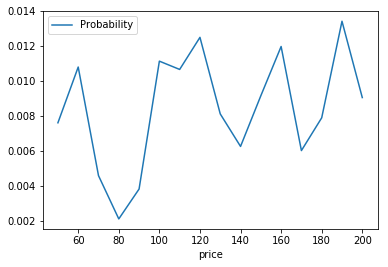

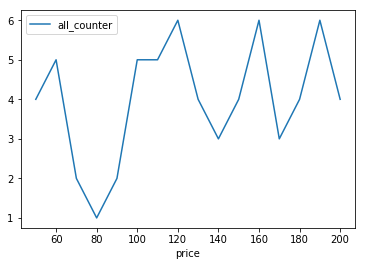

In [61]:
price_table['Probability'] = price_table['all_counter'] / price_table['picked_counter']
price_table.plot(x='price', y='Probability')
price_table.plot(x='price', y='all_counter')

In [126]:
X['cleaning_fee'].median()

64.0

In [158]:
p = 'cleaning_fee'
p_data = list(range(0, 155, 5))
cleaning_fee_table = change_parameter(p, p_data)
cleaning_fee_table['Cleaning Fee'] = p_data

<Figure size 1520x480 with 0 Axes>

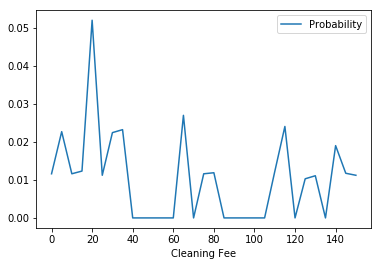

In [171]:
cleaning_fee_table['Probability'] = cleaning_fee_table['Guest Count'] / cleaning_fee_table['Shuffled Count']
figure(num=None, figsize=(19, 6), dpi=80, facecolor='w', edgecolor='k')
cleaning_fee_table.plot(x='Cleaning Fee', y='Probability')
plt.show()

In [52]:
p = 'minimum_nights'
p_data = list(range(30))
minnight_table = change_parameter(p, p_data)

In [113]:
p = 'price'
p_data = list(range(50, 200, 5 ))

In [114]:
len(p_data)

30

In [112]:
minnight_table.shape

(30, 4)

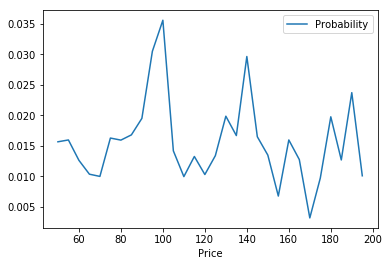

In [120]:
minnight_table['Price'] = p_data
minnight_table['Probability'] = minnight_table['all_counter'] / minnight_table['picked_counter'] * 2
minnight_table
minnight_table.plot(x='Price', y='Probability')
#minnight_table.plot(x='price', y='all_counter')